# 2D Shallow Water Equations 🌊

This notebook is a devito reimplementation from this [notebook](https://github.com/daniel-koehn/Differential-equations-earth-system/blob/e291791b6d6b32f776af01532b37a9869c5cf569/10_Shallow_Water_Equation_2D/01_2D_Shallow_Water_Equations.ipynb). We will use an approximation to the Navier-Stokes equations - the 2D Shallow Water equations - in order to model the propagation of Tsunamis.

I've only made minor modifications to the text, in order to make it more compatible to the new coding format.

Author: Átila Saraiva Q. Soares.

## Governing Equations

Starting from the continuity and momentum conservation equations, we want to model the following problem:

<img src="images/shallow_water_sketch.png" style="width: 800px;"/>

For a given bathymetry model, which can include a complex seafloor topography, we want to model the amplitudes, speed and interaction of waves at the seasurface. At a given point $(x,\; y)$, the thickness of the water column between the seafloor and undisturbed water surface is defined by the variable $h$, while the wave amplitude is $\eta$ and therefore the whole thickness of the water column $D = h + \eta$.

Using appropriate boundary conditions at the water surface/seafloor, assuming that the horizontal wavelength of the modelled waves are much larger than the water depth and integrating the conservation of mass and momentum equations over the water column, we can derive the following equations to decribe wave propagation 

\begin{equation}
\begin{split}
\frac{\partial \eta}{\partial t} &+ \frac{\partial M}{\partial x} + \frac{\partial N}{\partial y} = 0\\
\frac{\partial M}{\partial t} &+ \frac{\partial}{\partial x} \biggl(\frac{M^2}{D}\biggr) + \frac{\partial}{\partial y} \biggl(\frac{MN}{D}\biggr) + g D \frac{\partial \eta}{\partial x} + \frac{g \alpha^2}{D^{7/3}} M \sqrt{M^2+N^2} = 0\\
\frac{\partial N}{\partial t} &+ \frac{\partial}{\partial x} \biggl(\frac{MN}{D}\biggr) + \frac{\partial}{\partial y} \biggl(\frac{N^2}{D}\biggr) + g D \frac{\partial \eta}{\partial y} + \frac{g \alpha^2}{D^{7/3}} N \sqrt{M^2+N^2} = 0
\end{split}
\tag{1}
\end{equation}

known as **2D Shallow Water Equations (SWE)**. The derivation of these equations is beyond the scope of this notebook. Therefore, I refer to the [Tsunami Modelling Handbook](http://www.tsunami.civil.tohoku.ac.jp/hokusai3/J/projects/manual-ver-3.1.pdf) and the lecture [Shallow Water Derivation and Applications by Christian Kühbacher](http://www.mathematik.tu-dortmund.de/lsiii/cms/papers/Kuehbacher2009.pdf) for further details.

In Eq. (1) the discharge fluxes $M,\; N$ in x- and y-direction, respectively are given by

\begin{equation}
\begin{split}
M & = \int_{-h}^\eta u dz = u(h+\eta) = uD\\
N & = \int_{-h}^\eta v dz = v(h+\eta) = vD\\
\end{split}
\tag{2}
\end{equation}

with the horizontal velocity components $u,\;v$ in x- and y-direction, while $g$ denotes the gravity acceleration. The terms $\frac{g \alpha^2}{D^{7/3}} M \sqrt{M^2+N^2}$ and $\frac{g \alpha^2}{D^{7/3}} N \sqrt{M^2+N^2}$ describe the influence of seafloor friction on the wave amplitude. $\alpha$ denotes the Manning's roughness which can be as small as 0.01 for neat cement or smooth metal up to 0.06 for very poor natural channels (see [Tsunami modelling handbook](http://www.tsunami.civil.tohoku.ac.jp/hokusai3/J/projects/manual-ver-3.1.pdf)).

The Shallow Water Equations can be applied to 

- Tsunami prediction
- Atmospheric flow
- Storm surges
- Flows around structures
- Planetary flows

and easily extended to incorporate the effects of Coriolis forces, tides or wind stress.

## Operator implementation

This is a simple function which returns the operator that solves this equation. The important part is the operator, which contains all the equations expressed above.

In [1]:
from devito import Eq, TimeFunction, sqrt, Function, Operator, Grid, solve, ConditionalDimension
from matplotlib import pyplot as plt
import numpy as np


def ForwardOperator(etasave, eta, M, N, h, D, g, alpha, grid):
    """
    Operator that solves the equations expressed above.
    It computes and returns the discharge fluxes M, N and wave height eta from
    the 2D Shallow water equation using the FTCS finite difference method.
    
    Parameters
    ----------
    eta : TimeFunction
        The initial wave height field as a 2D array of floats.
    M : TimeFunction
        The initial discharge flux field in x-direction as a 2D array of floats.
    N : TimeFunction
        The initial discharge flux field in y-direction as a 2D array of floats.
    h : Function
        Bathymetry model as a 2D array of floats.
    D : Function
        Total thickness of the water column.
    g : float
        gravity acceleration.
    alpha : float
        Manning's roughness coefficient.
    etasave : TimeFunction
        Function that is sampled in a different interval than the normal propagation
        and is responsible for saving the snapshots required for the following
        animations.
    """
    
    eps = np.finfo(grid.dtype).eps
    
    # Friction term expresses the loss of amplitude from the friction with the seafloor
    frictionTerm = g * alpha**2 * sqrt(M**2 + N**2) / D**(7./3.)

    # System of equations
    pde_eta = Eq(eta.dt + M.dxc + N.dyc)
    pde_M   = Eq(M.dt + (M**2/D).dxc + (M*N/D).dyc + g*D*eta.forward.dxc + frictionTerm*M)
    pde_N   = Eq(N.dt + (M.forward*N/D).dxc + (N**2/D).dyc + g*D*eta.forward.dyc + g * alpha**2 * sqrt(M.forward**2 + N**2) / D**(7./3.)*N)

    # Defining boundary conditions
    x, y = grid.dimensions
    t    = grid.stepping_dim
    bc_left   = Eq(eta[t+1, 0, y], eta[t+1, 1, y])
    bc_right  = Eq(eta[t+1, nx-1, y], eta[t+1, nx-2, y])
    bc_top    = Eq(eta[t+1, x, 0], eta[t+1, x, 1])
    bc_bottom = Eq(eta[t+1, x, ny-1], eta[t+1, x, ny-2])

    stencil_eta = solve(pde_eta, eta.forward)
    stencil_M   = solve(pde_M, M.forward)
    stencil_N   = solve(pde_N, N.forward)

    # Equations with the forward in time term isolated
    update_eta  = Eq(eta.forward, stencil_eta, subdomain=grid.interior)
    update_M    = Eq(M.forward, stencil_M, subdomain=grid.interior)
    update_N    = Eq(N.forward, stencil_N, subdomain=grid.interior)
    eq_D        = Eq(D, eta.forward + h)

    return Operator([update_eta, bc_left, bc_right, bc_top, bc_bottom,
                     update_M, update_N, eq_D] + [Eq(etasave, eta)])
    #return Operator([update_eta, update_M, update_N, eq_D] + [Eq(etasave, eta)])

The following function transforms the saved wavefield snapshots and transform them into a video compatible with jupyter notebook.

In [2]:
#NBVAL_IGNORE_OUTPUT
#NBVAL_SKIP
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def snaps2video (eta, title):
    fig, ax = plt.subplots()
    matrice = ax.imshow(eta.data[0, :, :].T, vmin=-1, vmax=1, cmap="seismic")
    plt.colorbar(matrice)

    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(title)    

    def update(i):
        matrice.set_array(eta.data[i, :, :].T)
        return matrice,

    # Animation
    ani = animation.FuncAnimation(fig, update, frames=nsnaps, interval=50, blit=True)

    #plt.show()
    plt.close(ani._fig)
    display(HTML(ani.to_html5_video()))

## Example I: Tsunami in an ocean with constant depth

After writing the `Shallow_water_2D` code and all the required functions attached to it, we can define and run our first 2D Tsunami modelling run.

Let's assume that the ocean model is $ L_x = 100\; m$ in x-direction and $L_y = 100\; m$ in y-direction. The model is discretized with $nx=401$ gridpoints in x-direction and $ny=401$ gridpoints in y-direction, respectively.

In this first modelling run, we assume a constant bathymetry $h=50\;m$. The initial wave height field $\eta_0$ is defined as a Gaussian at the center of the model, with a half-width of 10 m and an amplitude of 0.5 m. Regarding the initial discharge fluxes, we assume that 

\begin{equation}
\begin{split}
M_0(x,y) &= 100 \eta_0(x,y)\\
N_0(x,y) &= 0\\
\end{split}\notag
\end{equation}

Furthermore, Dirichlet boundary conditions for the discharge fluxes $M,\;N$ are assumed at all boundaries: 

\begin{equation}
\begin{split}
M(0,y) &= M(L_x,y) = M(x,0) = M(x,L_y) = 0\\  
N(0,y) &= N(L_x,y) = N(x,0) = N(x,L_y) = 0\\  
\end{split} \notag
\end{equation}

For the wave height field $\eta$, it is essential that Neumann boundary conditions are set at all boundaries:

\begin{equation}
\begin{split}
&\frac{\partial \eta}{\partial x}(0,y) = 0\\
&\frac{\partial \eta}{\partial x}(L_x,y) = 0\\
&\frac{\partial \eta}{\partial y}(x,0) = 0\\
&\frac{\partial \eta}{\partial y}(x,L_y) = 0\\
\end{split}\notag
\end{equation}

in order to avoid the occurence of high frequency artifacts, when waves are interacting with the boundaries. Notice, that the assumed boundary conditions lead to significant boundary reflections which might be not realistic for a given problem.

Let's assume the gravity $g = 9.81$ and the Manning's roughness coefficient $\alpha = 0.025$ for the all the remaining examples.

In [3]:
Lx    = 100.0   # width of the mantle in the x direction []
Ly    = 100.0   # thickness of the mantle in the y direction []
nx    = 401     # number of points in the x direction
ny    = 401     # number of points in the y direction
dx    = Lx / (nx - 1)  # grid spacing in the x direction []
dy    = Ly / (ny - 1)  # grid spacing in the y direction []
g     = 9.81  # gravity acceleration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition

# Maximum wave propagation time [s]
Tmax  = 6.
dt    = 1/4500.
nt    = (int)(Tmax/dt)
print(dt, nt)

x = np.linspace(0.0, Lx, num=nx)
y = np.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = np.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 50 m
h0 = 50. * np.ones_like(X)

# Define initial eta Gaussian distribution [m]
eta0 = 0.5 * np.exp(-((X-50)**2/10)-((Y-50)**2/10))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + 50.

grid  = Grid(shape=(ny, nx), extent=(Ly, Lx), dtype=np.float64)

0.00022222222222222223 27000


In [4]:
nsnaps = 400

# Defining symbolic functions
eta   = TimeFunction(name='eta', grid=grid, space_order=2)
M     = TimeFunction(name='M', grid=grid, space_order=2)
N     = TimeFunction(name='N', grid=grid, space_order=2)
h     = Function(name='h', grid=grid)
D     = Function(name='D', grid=grid)

# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()

# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)


# Compile the operator
op = ForwardOperator(etasave, eta, M, N, h, D, g, alpha, grid)

# Use the operator
#op(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)
op.apply(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

#snaps2video(etasave, "Modeling a tsunami in an ocean with constant depth")

The nt/nsnaps factor is 68


Operator `Kernel` ran in 13.50 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1.8056899999998945, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.4811249999999872, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.3801010000000274, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.19931100000000002, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=10.624037000000286, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [5]:
it = int(400*14/20)+6

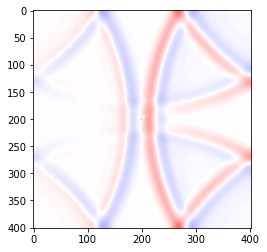

In [6]:
plt.imshow(etasave.data[it].T, vmin=-1, vmax=1, cmap="seismic")

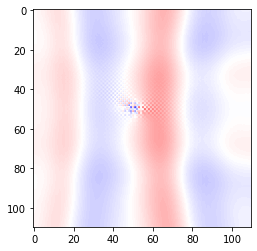

In [7]:
plt.imshow(etasave.data[it,150:260,150:260].T, vmin=-1, vmax=1, cmap="seismic")

In [8]:
print(etasave.data[it,150:260,150:260].T)

[[ 0.01467833  0.01522189  0.0187978  ... -0.02984874 -0.03000219
  -0.03027211]
 [ 0.01448977  0.01480726  0.01845126 ... -0.03103429 -0.0312938
  -0.03157819]
 [ 0.01383475  0.01426316  0.01761146 ... -0.03286121 -0.0330991
  -0.03348729]
 ...
 [ 0.01683908  0.0180191   0.02241575 ... -0.02570854 -0.02554021
  -0.02536015]
 [ 0.01729975  0.01853362  0.02311145 ... -0.02565763 -0.02552497
  -0.02523308]
 [ 0.0176604   0.01909468  0.02370767 ... -0.02565571 -0.02542711
  -0.02512885]]


In [9]:
print(etasave.data[it,195:250,195:205].T)

[[-0.0763196   0.08128578 -0.05801573  0.08619979 -0.05357182  0.04951461
  -0.01644105  0.03428419  0.07055257  0.05337834  0.12915518  0.07849912
   0.16448477  0.10429235  0.18807377  0.12638843  0.20110273  0.14064854
   0.20224984  0.14408754  0.19092949  0.13557002  0.16808212  0.11609346
   0.13625272  0.08853386  0.09915342  0.05686609  0.06090194  0.02517743
   0.02525224 -0.00316666 -0.00494807 -0.02599152 -0.02801173 -0.04237652
  -0.04342594 -0.05239971 -0.05167964 -0.05672877 -0.05392712 -0.05624684
  -0.05154693 -0.05185109 -0.04576064 -0.0444472  -0.03752283 -0.03504985
  -0.0277429  -0.02485576 -0.01760575 -0.0151887  -0.00859941 -0.00728184
  -0.00207085]
 [ 0.11813358 -0.09436422  0.12393486 -0.10014517  0.06561393  0.00516319
   0.06617611  0.02571011  0.02267549  0.07499253  0.04173455  0.14160542
   0.07896148  0.18433768  0.10990241  0.20477904  0.13112163  0.20983828
   0.14145834  0.20212796  0.13965037  0.18280747  0.1257742   0.15378899
   0.10183672  0.118234

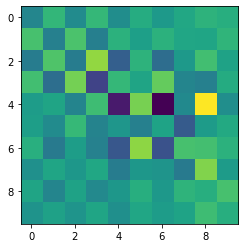

In [10]:
plt.imshow(etasave.data[it,195:205,195:205].T)

In [11]:
print(etasave.data[it,195:205,195:205].min())

-0.4373138739586962


In [12]:
snaps2video(etasave, "Modeling a tsunami in an ocean with constant depth")

Let's take a look on what the code looks like

In [ ]:
# To look at the code, uncomment the line below
print(op.ccode)

## Example II: Two Tsunamis in ocean with constant depth

In example II, we will model the propagation and interaction of two Tsunamis, where the initial conditions for the wave height field $\eta_0$ consists of Gaussian functions with opposite sign located at $(x_1,\;y_1) = (35\; m,\; 35\; m)$ and $(x_2,\;y_2) = (65\; m,\; 65\; m)$. All other modelling parameters remain the same ...

In [ ]:
# Define constant ocean depth profile h = 50 m
h0 = 50 * np.ones_like(X)

# Define initial Gaussian eta distribution [m]
eta0 = 0.5 * np.exp(-((X-35)**2/10)-((Y-35)**2/10)) # first Tsunami source
eta0 -= 0.5 * np.exp(-((X-65)**2/10)-((Y-65)**2/10)) # add second Tsunami source

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + h0

# Maximum wave propagation time [s]
Tmax = 2.
dt = 1/8000.
nt = (int)(Tmax/dt)

In [ ]:
# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()

# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)

# Compile the operator
op = ForwardOperator(etasave, eta, M, N, h, D, g, alpha)

# Use the operator. No need to recompile since the etasave factor is smaller
# than before
op(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

snaps2video(etasave, "Modeling two tsunamis in ocean with constant depth")

## Example III: Tsunami in an ocean with 1D Tanh depth variation

So far, so good, we can achieve stable and accurate modelling results. However, a constant bathymetry model is a little too simple. In this example, we assume that the bathymetry decreases with a $\tanh$ function from the left to the right boundary in x-direction. Let 's place a Tsunami source at $(x_1,\;y_1) = (30\; m,\; 50\; m)$ and see what 's happening ...

In [ ]:
# Define depth profile h [m]
h0 = 50 - 45 * np.tanh((X-70.)/8.)

# Define initial eta [m]
eta0 = 0.5 * np.exp(-((X-30)**2/10)-((Y-50)**2/20))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + h0

# Maximum wave propagation time [s]
Tmax = 2.
dt = 1/8000.
nt = (int)(Tmax/dt)

In [ ]:
# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()

# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)

# Use the operator
op(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

snaps2video(etasave, "Modeling a tsunami in an ocean with 1D Tanh depth variation")

## Example IV: Tsunami in an ocean with a seamount

What happens if we have a constant bathymetry, except for a small seamount reaching 5 m below the water surface? Lets define the model parameters:

In [ ]:
# Define constant ocean depth profile h = 50 m
h0 = 50. * np.ones_like(X)

# Adding seamount to seafloor topography
h0 -= 45. * np.exp(-((X-50)**2/20)-((Y-50)**2/20))

# Define initial eta [m]
eta0 = 0.5 * np.exp(-((X-30)**2/5)-((Y-50)**2/5))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + h0

# Maximum wave propagation time [s]
Tmax = 2.
dt = 1/8000.
nt = (int)(Tmax/dt)

In [ ]:
# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()

# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)

# Use the operator
op(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

snaps2video(etasave, "Modeling a tsunami in an ocean with a seamount")

## Example V: Tsunami in an ocean with random seafloor topography variations

Another modelling idea: what is the influence of the roughness of the seafloor topography. First, we add some random perturbations on the constant bathymetry model $h_0$ by using the `random.rand` function from the `NumPy` library. To smooth the random perturbations, we apply the `gaussian_filter` from the `SciPy`library:

In [ ]:
from scipy.ndimage import gaussian_filter

# Define constant ocean depth profile h = 30 m
h0 = 30. * np.ones_like(X)

# Add random seafloor perturbation of +- 5m
pert = 5.   # perturbation amplitude

np.random.seed(102034)
r = 2.0 * (np.random.rand(ny, nx) - 0.5) * pert # create random number perturbations
r = gaussian_filter(r, sigma=8) # smooth random number perturbation
h0 = h0 * (1 + r) # add perturbations to constant seafloor

# Define initial eta [m]
eta0 = 0.5 * np.exp(-((X-30)**2/5)-((Y-50)**2/5))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + h0

# Maximum wave propagation time [s]
Tmax = 3.
dt = 1/8000.
nt = (int)(Tmax/dt)

In [ ]:
# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()
nsnaps = nt
# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)


# Compile the operator again to create a new code since the 
# etasave factor is much higher than the one in example I.
op = ForwardOperator(etasave, eta, M, N, h, D, g, alpha)

# Use the operator
op(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

snaps2video(etasave, "Modeling a tsunami in an ocean with\n random seafloor topography variations")

Notice how in this example I've had to regenerate the operator code. This wasn't necessary in the previous examples as the factor was smaller than the one in the first example. The one in the first example is 270, and in the second to fourth is 240, going to 320 in the fifth example. The etasave function takes snapshots from 270 index jumps, checking if the current time is divisible by 270.
When the factor goes above the 270 mark, as in the case of example V, the time goes up to 32000, which in the time 29700, the division 29700/270 = 101, exceding the time axis dimension of etasave of 100.
Since the factor is reduced in the examples II-IV, the last few snapshots are zeroed, since the time doesn't go above the 27000 threshold, which is equivalent to the index 100 of the etasave grid.

## Example VI: 2D circular dam break problem

As a final modelling example, let's take a look at an (academic) engineering problem: a tsunami induced by the collapse of a circular dam in a lake with a constant bathymetry of 30 m. We only need to set the wave height in a circle with radius $r_0 = 5\; m$ to $\eta_0 = 0.5 \; m$ and to zero everywhere else. To avoid the occurence of high frequency artifacts in the wavefield, known as numerical grid dispersion, we apply a Gaussian filter to the initial wave height. To achieve a symmetric dam collapse, the initial discharge fluxes $M_0,N_0$ are set to equal values.

In [ ]:
# Define constant ocean depth profile h = 30 m
h0 = 30. * np.ones_like(X)

# Define initial eta [m]
eta0 = np.zeros_like(X)

# Define mask for circular dam location with radius r0
r0 = 5.
mask = np.where(np.sqrt((X-50)**2 + (Y-50)**2) <= r0)

# Set wave height in dam to 0.5 m
eta0[mask] = 0.5

# Smooth dam boundaries with gaussian filter
eta0 = gaussian_filter(eta0, sigma=8) # smooth random number perturbation

# Define initial M and N
M0 = 1. * eta0
N0 = 1. * M0
D0 = eta0 + h0

# Maximum wave propagation time [s]
Tmax = 3.
dt = 1/8000.
nt = (int)(Tmax/dt)

In [ ]:
# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()

# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)

# Use the operator
op(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

snaps2video(etasave, "Modeling a 2D circular dam break problem")

## What we learned:

* How to solve the 2D Shallow Water Equation using the FTCS finite difference scheme.

* Propagation of (multiple) Tsunamis in an ocean with constant bathymetry.

* Tsunamis reaching shallow waters near a coast will slow down, their wavelength decrease, while their wave height increases.

* The influence of a seamount and roughness of the seafloor topoghraphy on the Tsunami wavefield.

* Tsunami modelling for engineering problems, like the collapse of dams.